### Clustering algorithm based on underlying probability function

In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
from transform_waze_raw_functions import *
import math
import matplotlib.pyplot as plt
import datetime
from ast import literal_eval
from nltk.cluster import KMeansClusterer
from scipy.stats import wasserstein_distance
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

Let’s focus on alerts reporting jams. For a given street, our goal is to approach the underlying temporal probability density function of jams. 

In [4]:
df = pd.read_csv('data/al_complete.csv')
df_jam = df[df['type'] == 'JAM'].reset_index(drop=True)
jm = transform_alerts(df_jam)

To do so, we counted the number of alerts for each hour of the day in that street, and plotted the corresponding histogram. For instance, the temporal profile of Richmond Hill Road is the following:

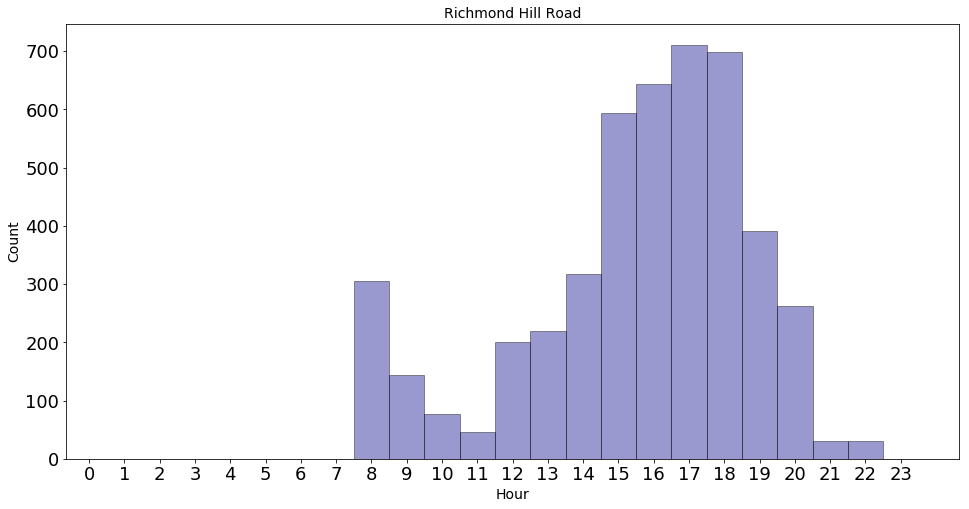

In [21]:
street = 'Richmond Hill Rd'
bins = np.arange(24)
plt.figure(figsize=(16,8))
sns.distplot(jm[jm['street'] == street]['hour'].astype(int), hist=True, kde=False, color = 'darkblue', 
             hist_kws={'range': [0,23], 'edgecolor':'black'}, bins=bins)
plt.xticks(bins-.5, bins)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Richmond Hill Road', fontsize=14)
plt.savefig('richmond_hist.png')
plt.show()

By normalizing this histogram, we can get the probabilities estimates. Hence, in each street, the jams are following a multinomial distribution. We computed those estimates for all streets (stored in prob_street).

In [5]:
jm['hour'] = jm.pub_utc_date.str[11:13].astype(int)
df_jm = jm[['uuid', 'street', 'hour']].groupby(['street', 'hour']).count().reset_index().rename(columns={'uuid': 'sum_street_hour'})
sum_hour = jm[['uuid', 'hour']].groupby(['hour']).count().reset_index().rename(columns={'uuid': 'sum_hour'})
df_jm = pd.merge(df_jm, sum_hour, right_on='hour', left_on='hour')
df_jm['prob_hour'] = df_jm['sum_street_hour'] / df_jm['sum_hour']

sum_street = jm[['uuid', 'street']].groupby(['street']).count().reset_index().rename(columns={'uuid': 'sum_street'})
df_jm = pd.merge(df_jm, sum_street, right_on='street', left_on='street')
df_jm['prob_street'] = df_jm['sum_street_hour'] / df_jm['sum_street']

In [18]:
df_jm.head()

,street,hour,sum_street_hour,sum_hour,prob_hour,sum_street,prob_street
0,8 St,6,25,37164,0.000673,25,1.000000
1,Alaska St,6,15,37164,0.000404,44,0.340909
2,Alaska St,16,15,68750,0.000218,44,0.340909
3,Alaska St,17,14,71778,0.000195,44,0.318182
4,Amboy Rd,6,361,37164,0.009714,4247,0.085001


The next step is to regroup streets in clusters based on their temporal profile with k-means algorithm. We implemented it with Wasserstein metric, that measures the distance between two probability distributions.

In [6]:
df_street = df_jm.groupby('street').agg({'hour': lambda x:list(x), 'prob_street': lambda x:list(x)}).reset_index()

In [8]:
df_street.head()

,street,hour,prob_street
0,8 St,[6],[1.0]
1,Abingdon Ave,"[9, 13]","[0.5, 0.5]"
2,Ada Dr,[21],[1.0]
3,Adams Ave,[21],[1.0]
4,Admiralty Loop,[23],[1.0]


In [3]:
def custom_distance(u, v):
    return wasserstein_distance(np.arange(24)[u > 0], np.arange(24)[v > 0], u[u > 0], v[v > 0])

class KMeansClusters(BaseEstimator, TransformerMixin):
    
    def __init__(self, k=200):
        self.k = k
        self.distance = custom_distance
        self.model = KMeansClusterer(self.k, self.distance, avoid_empty_clusters=True)
    
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        return self.model.cluster(documents, assign_clusters=True)

In [10]:
X = np.array(df_street[['hour','prob_street']].values.tolist())
Y = np.zeros((np.shape(X)[0], 24))
for idx, val in enumerate(X):
    for i in np.arange(len(val[0])):
        Y[idx][val[0][i]] = val[1][i]

In [12]:
model = KMeansClusters(k=5)
clusters = model.fit_transform(Y)

In [13]:
df_street['cluster'] = clusters

In [14]:
df_street.head()

,street,hour,prob_street,cluster
0,8 St,[6],[1.0],4
1,Abingdon Ave,"[9, 13]","[0.5, 0.5]",3
2,Ada Dr,[21],[1.0],2
3,Adams Ave,[21],[1.0],2
4,Admiralty Loop,[23],[1.0],2


With an arbitrary number of five clusters, we get roughly balanced groups with the following centroids:

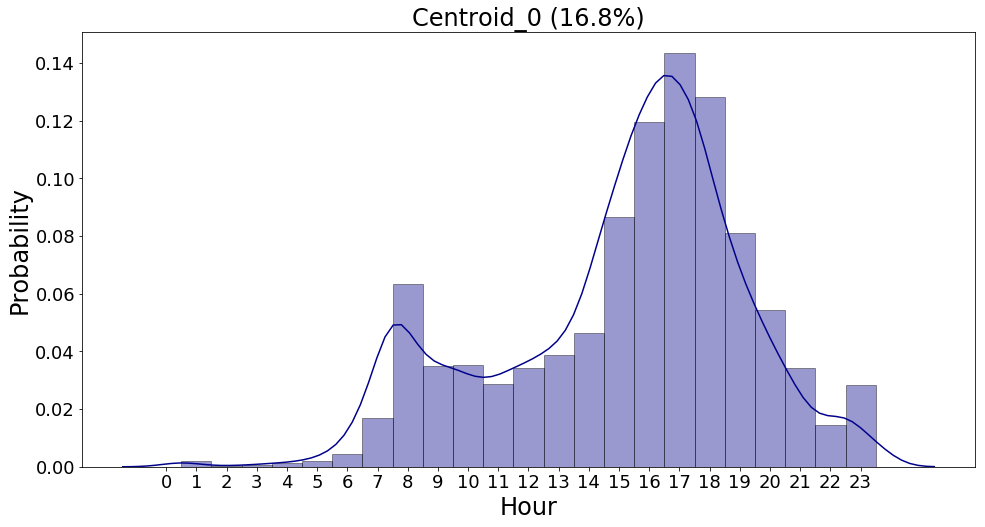

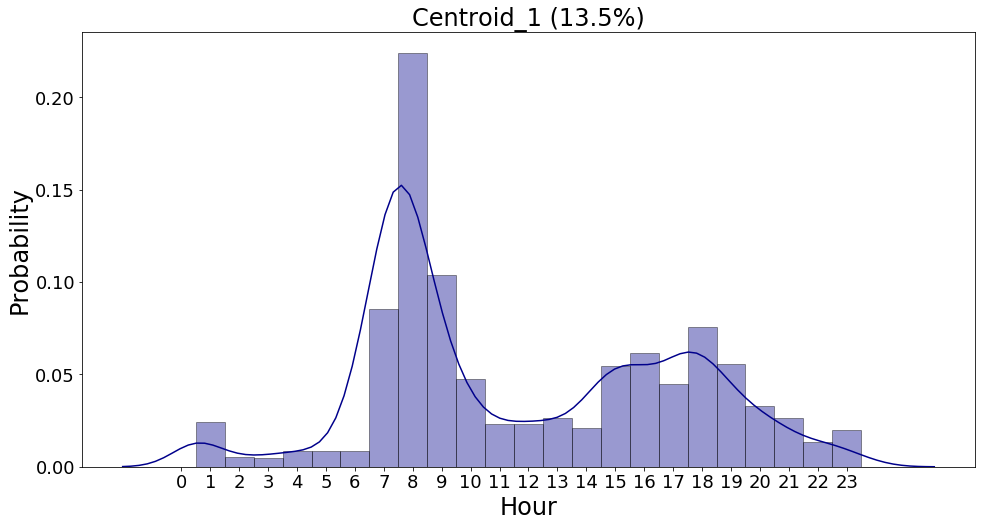

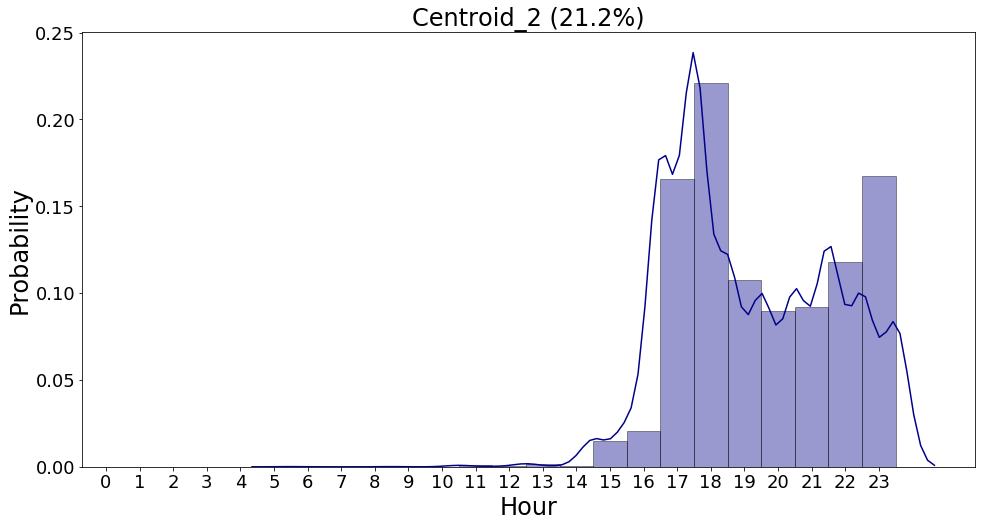

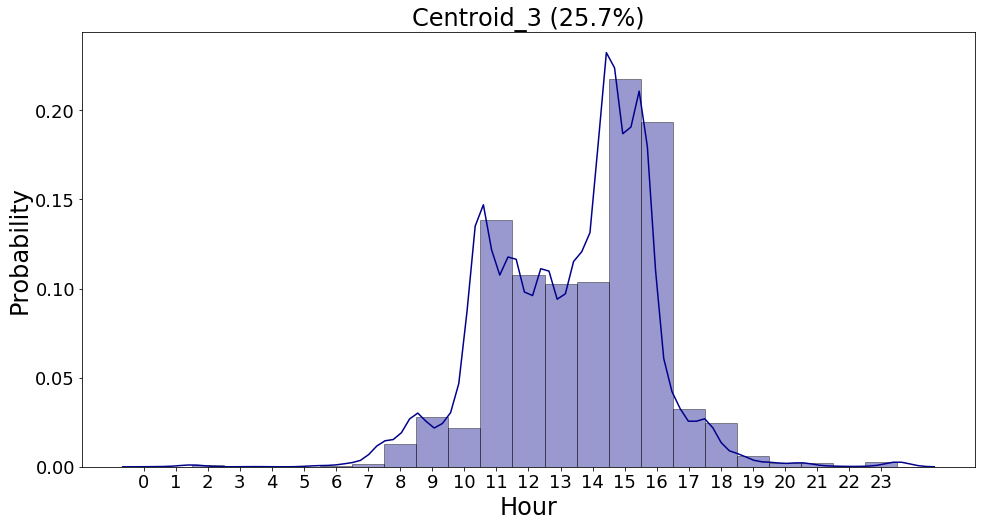

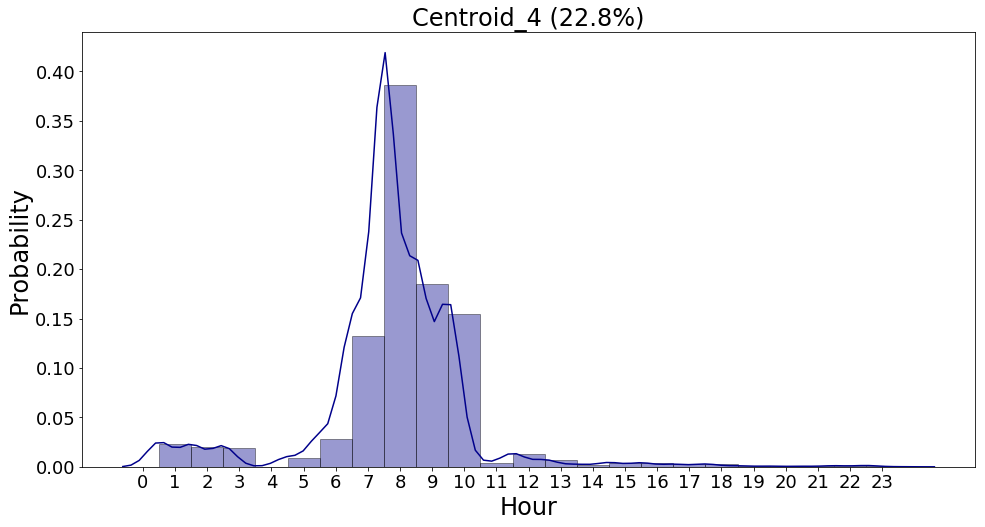

In [22]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
for i in np.arange(5):
    pct = np.round(df_street[df_street['cluster'] == i].shape[0]/df_street.shape[0]*100, 1)
    L = []
    for idx, val in enumerate(np.random.multinomial(10000, list(np.mean(Y[df_street['cluster'] == i], axis=0)))):
        L.append([idx]*val)
    result = sum(L, [])
    bins = np.arange(24)
    plt.figure(figsize=(16,8))
    sns.distplot(result, hist=True, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'}, bins=bins)
    plt.xticks(bins-.5, bins)
    plt.xlabel('Hour', fontsize=24)
    plt.ylabel('Probability', fontsize=24)
    plt.title('Centroid_' + str(i) + ' (' + str(pct) + '%)', fontsize=24)
    plt.savefig('image/centroid_' + str(i) + '.png')
    plt.show()